In this competition, you are allowed to use one of the following options: Decision Trees, Rule-based Models, k-Nearest Neighbor, or Naïve Bayes Classifier. If not, you will get a 0 score.

You can use all the deep learning library (pytorch, tensorflow, etc.)

Only individual team is allowed. You should do this competition by yourself.

You must submit your training code to the PLMS. TAs can check whether your code reproduces the results or not. Any significant differences in the reproduced results will result in severe penalties.

If anything that violates the honor code is found, TAs will contact you. If you cannot answer reasonably, you will get severe penalties.

**Evaluation criteria : Weighted F1 score**

**In the classification task, your goal is to predict the position of the player. (Column ‘position’ in csv file)**

### Import modules

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from scipy import stats
from sklearn.manifold import TSNE

### Define and preprocessing Dataset

c:\Users\carot\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\carot\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


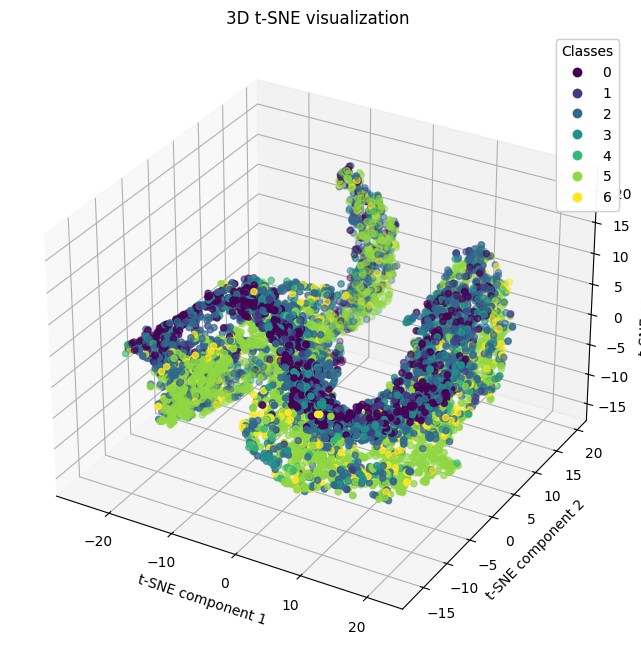

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
# train_df['ShootingEfficiency'] = train_df['FG_PCT'] * train_df['FG3_PCT']
# train_df['TotalAttempts'] = train_df['FGA'] + train_df['FG3A'] + train_df['FTA']
train_df.dropna(inplace=True)
# train_df.fillna(train_df.mean(), inplace=True)

z_scores = np.abs(stats.zscore(train_df.select_dtypes(include=[np.number])))
train_df = train_df[(z_scores < 3).all(axis=1)]

# X = train_df.drop(['position', 'SEASON_ID', 'TEAM_ID', 'PLAYER_AGE', 'MIN'], axis=1)
X = train_df.drop(['position', 'SEASON_ID', 'TEAM_ID'], axis=1)
y = train_df['position']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(X)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=y_encoded, cmap='viridis', marker='o')
legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)
ax.set_title('3D t-SNE visualization')
ax.set_xlabel('t-SNE component 1')
ax.set_ylabel('t-SNE component 2')
ax.set_zlabel('t-SNE component 3')
plt.show()

X_train, X_val, y_train, y_val = train_test_split(X_tsne, y_encoded, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

### kNN

In [4]:
knn = KNeighborsClassifier()
param_grid_knn = {
    'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev']
}
grid_knn = GridSearchCV(knn, param_grid_knn, scoring='f1_weighted', cv=skf)
grid_knn.fit(X_train, y_train)

print(f'K-Nearest Neighbors Best parameters: {grid_knn.best_params_}, Best Score: {grid_knn.best_score_}')

best_knn_model = grid_knn.best_estimator_
y_val_pred = best_knn_model.predict(X_val)

val_f1_score = f1_score(y_val, y_val_pred, average='weighted')
print(f'Validation Weighted F1 Score: {val_f1_score}')

K-Nearest Neighbors Best parameters: {'metric': 'chebyshev', 'n_neighbors': 10, 'weights': 'distance'}, Best Score: 0.5254721693240425
Validation Weighted F1 Score: 0.5289607137313037


### Predict test data

In [ ]:
X_test = test_df.drop(['ID', 'SEASON_ID', 'TEAM_ID'], axis=1)
X_test = X_test.reindex(columns=X.columns, fill_value=0)

tsne = TSNE(n_components=3, random_state=42)
X_test_tsne = tsne.fit_transform(X_test)

X_test_tsne = scaler.transform(X_test_tsne)

models = {
    'kNN': best_knn_model,
}

for name, model in models.items():
    y_test_pred = model.predict(X_test_tsne)
    y_test_pred_decoded = label_encoder.inverse_transform(y_test_pred)
    submission_df = pd.DataFrame({'ID': test_df['ID'], 'position': y_test_pred_decoded})
    submission_file_path = f'submission_{name}.csv'
    submission_df.to_csv(submission_file_path, index=False)
    print(f"{name} Done.")



DT Done.
kNN Done.
NB Done.
Rule-based Done.
